# Damped Harmonic Oscillator

* **목표:** 시간 t에 따른 위치 $u(t)$를 예측하는 신경망 학습
* **초기 조건:** u(0) = 1 (1미터에서 놓음), u'(0) = 0 (정지 상태에서 출발)
* **설정 값:** m=1, \mu=2, k=400 (가벼운 물체, 약간의 마찰, 강한 스프링)

🚀 학습 시작...
Epoch 0: Loss 42373.308594 (Data: 0.368693, Physics: 42372.941406)
Epoch 1000: Loss 1.748571 (Data: 0.991164, Physics: 0.757407)
Epoch 2000: Loss 1.266842 (Data: 0.995169, Physics: 0.271673)
Epoch 3000: Loss 1.048253 (Data: 0.998760, Physics: 0.049494)
Epoch 4000: Loss 1.012344 (Data: 1.000474, Physics: 0.011870)
Epoch 5000: Loss 1.008837 (Data: 1.000709, Physics: 0.008129)
Epoch 6000: Loss 1.006089 (Data: 1.000559, Physics: 0.005530)
Epoch 7000: Loss 1.003483 (Data: 1.000360, Physics: 0.003122)
Epoch 8000: Loss 1.002137 (Data: 1.000216, Physics: 0.001921)
Epoch 9000: Loss 1.014861 (Data: 0.999463, Physics: 0.015398)
Epoch 10000: Loss 1.000670 (Data: 1.000024, Physics: 0.000646)
Epoch 11000: Loss 1.038816 (Data: 1.000956, Physics: 0.037860)
Epoch 12000: Loss 1.028115 (Data: 1.000835, Physics: 0.027280)
Epoch 13000: Loss 5.903918 (Data: 1.011932, Physics: 4.891986)
Epoch 14000: Loss 0.999940 (Data: 0.999813, Physics: 0.000128)
✅ 학습 완료!


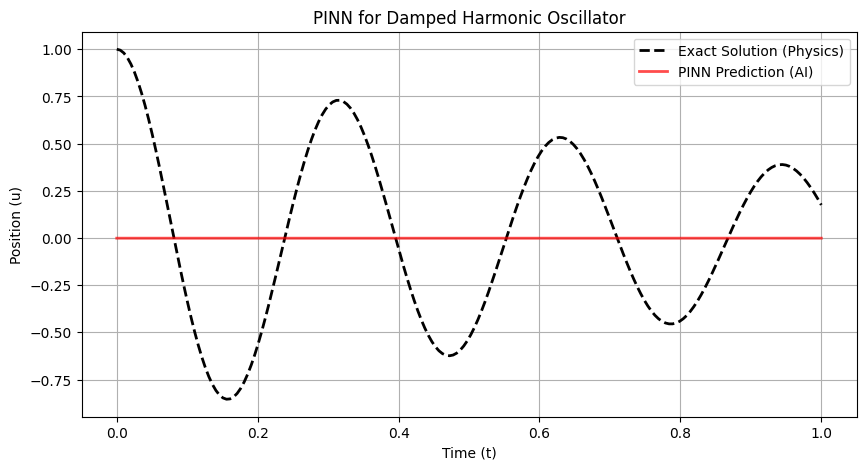

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. 시드 고정 (재현성 확보)
torch.manual_seed(1234)

# -----------------------------------------
# 2. PINN 모델 정의 (The Neural Network)
# -----------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # 입력(t) -> 은닉층 -> 출력(u)
        # Tanh는 미분 가능하고 부드러워 물리 문제에 적합합니다.
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.net(t)

# -----------------------------------------
# 3. 물리 법칙 정의 (Physics Loss)
# -----------------------------------------
def physics_loss(model, t):
    # t는 학습을 위해 생성한 Collocation Point (무작위 시간점들)
    t.requires_grad = True # 미분 추적 활성화
    
    u = model(t)
    
    # 1차 미분 (속도: du/dt)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    
    # 2차 미분 (가속도: d^2u/dt^2)
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]
    
    # 물리 방정식: m*u_tt + mu*u_t + k*u = 0
    # 잔차(Residual)가 0이 되도록 학습하는 것이 목표
    m = 1.0
    mu = 2.0
    k = 400.0 # under-damped (진동하며 감소)
    
    residual = m*u_tt + mu*u_t + k*u
    
    return torch.mean(residual ** 2)

# -----------------------------------------
# 4. 학습 데이터 및 루프 구성
# -----------------------------------------
# 모델 초기화
pinn = PINN()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# 학습 데이터 준비
# (1) 물리 법칙을 배울 시간 영역 (0초 ~ 1초 사이 무작위 점)
t_physics = torch.linspace(0, 1, 300).view(-1, 1).requires_grad_(True)

# (2) 초기 조건 (t=0일 때 u=1)
t_bc = torch.zeros(1, 1).requires_grad_(True) # time = 0
u_bc_target = torch.tensor([[1.0]])

# 학습 시작
epochs = 15000
loss_history = []

print("🚀 학습 시작...")
for i in range(epochs):
    optimizer.zero_grad()
    
    # Loss 1: 경계 조건 (Initial Condition Loss)
    # u(0)가 1이 되어야 함
    u_bc_pred = pinn(t_bc)
    loss_data = torch.mean((u_bc_pred - u_bc_target) ** 2)
    
    # Loss 2: 물리 방정식 잔차 (Physics Loss)
    # 방정식 F = ma 등을 만족해야 함
    loss_phy = physics_loss(pinn, t_physics)
    
    # Total Loss
    loss = loss_data + loss_phy # 가중치(lambda)를 줄 수도 있음 (예: loss_data * 100)
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if i % 1000 == 0:
        print(f"Epoch {i}: Loss {loss.item():.6f} (Data: {loss_data.item():.6f}, Physics: {loss_phy.item():.6f})")

print("✅ 학습 완료!")

# -----------------------------------------
# 5. 결과 시각화
# -----------------------------------------
# 예측값 생성
pinn.eval()
t_test = torch.linspace(0, 1, 200).view(-1, 1)
with torch.no_grad():
    u_pred = pinn(t_test).numpy()

# 정확한 정답(Analytical Solution) 계산 - 비교용
# 1*u'' + 2*u' + 400*u = 0 의 해
t_np = t_test.numpy()
# 해: u(t) = e^(-t) * (cos(19.97*t) + 0.05*sin(19.97*t))  (근사치)
d = 2 / (2 * 1) # damping ratio term
w0 = np.sqrt(400) # natural frequency
w = np.sqrt(w0**2 - d**2)
u_exact = np.exp(-d * t_np) * (np.cos(w * t_np) + (d/w)*np.sin(w * t_np))

plt.figure(figsize=(10, 5))
plt.title("PINN for Damped Harmonic Oscillator")
plt.plot(t_np, u_exact, 'k--', label="Exact Solution (Physics)", linewidth=2)
plt.plot(t_np, u_pred, 'r-', label="PINN Prediction (AI)", linewidth=2, alpha=0.7)
plt.xlabel("Time (t)")
plt.ylabel("Position (u)")
plt.legend()
plt.grid(True)
plt.show()

🚀 학습 시작 (Fourier Features + Hard Constraint)...
Epoch 0: Loss 151393.078125
Epoch 1000: Loss 5.870132
Epoch 2000: Loss 47.807095
Epoch 3000: Loss 2.647789
Epoch 4000: Loss 2.677519
Epoch 5000: Loss 0.828331
Epoch 6000: Loss 2.055417
Epoch 7000: Loss 3.638266
Epoch 8000: Loss 0.266476
Epoch 9000: Loss 1.286654
Epoch 10000: Loss 2.362687
Epoch 11000: Loss 29.415586
Epoch 12000: Loss 3.456775
Epoch 13000: Loss 4.939913
Epoch 14000: Loss 27.316116
Epoch 15000: Loss 16.427643
Epoch 16000: Loss 0.237567
Epoch 17000: Loss 4.473703
Epoch 18000: Loss 0.881763
Epoch 19000: Loss 21.537149
✅ 학습 완료!


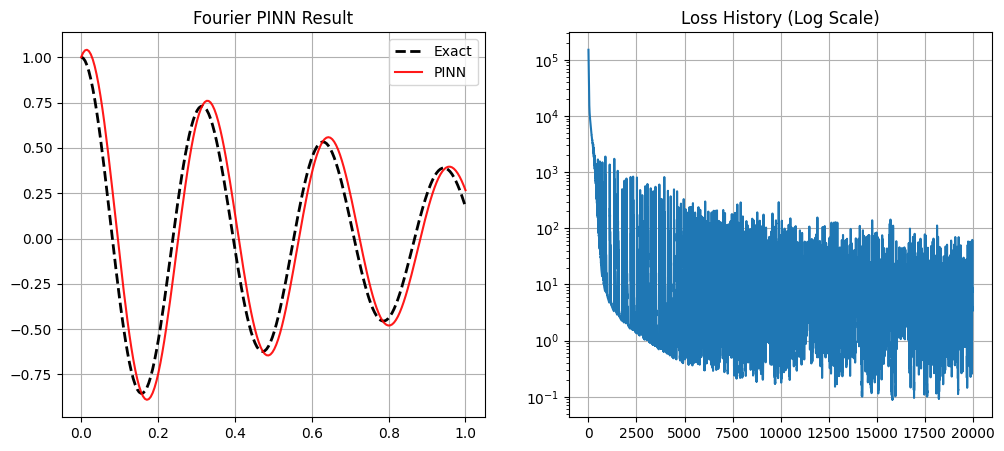

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1234)

# -----------------------------------------
# [기법 1] Fourier Feature Embedding Layer
# 입력 t를 고차원 주파수 영역으로 매핑하여 고주파 학습 능력 강화
# -----------------------------------------
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# -----------------------------------------
# PINN 모델 정의
# -----------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Fourier Feature로 차원을 1 -> 64로 확장
        self.embedding = FourierEmbedding(1, 64, scale=5.0) 
        
        self.net = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        # [기법 2] Hard Constraint (강제 제약)
        # 네트워크 출력 u = 1 + t * NN(t)
        # t=0일 때 무조건 1이 되도록 강제함. (초기 조건 Loss 불필요)
        feat = self.embedding(t)
        nn_out = self.net(feat)
        return 1.0 + t * nn_out

# -----------------------------------------
# 물리 법칙 Loss
# -----------------------------------------
def physics_loss(model, t):
    t.requires_grad = True
    u = model(t)
    
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]
    
    m, mu, k = 1.0, 2.0, 400.0
    residual = m*u_tt + mu*u_t + k*u
    return torch.mean(residual ** 2)

# -----------------------------------------
# 학습 준비
# -----------------------------------------
pinn = PINN()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Collocation Points
t_physics = torch.linspace(0, 1, 300).view(-1, 1).requires_grad_(True)

epochs = 20000
loss_history = []

print("🚀 학습 시작 (Fourier Features + Hard Constraint)...")

for i in range(epochs):
    optimizer.zero_grad()
    
    # Hard Constraint를 썼으므로 Boundary Loss는 계산할 필요가 없습니다!
    # 오직 물리 법칙만 잘 지키면 됩니다.
    loss = physics_loss(pinn, t_physics)
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if i % 1000 == 0:
        print(f"Epoch {i}: Loss {loss.item():.6f}")

print("✅ 학습 완료!")

# -----------------------------------------
# 결과 시각화
# -----------------------------------------
pinn.eval()
t_test = torch.linspace(0, 1, 200).view(-1, 1)
with torch.no_grad():
    u_pred = pinn(t_test).numpy()

# Exact Solution
t_np = t_test.numpy()
d = 1.0 # mu/2m = 2/2 = 1
w0 = np.sqrt(400)
w = np.sqrt(w0**2 - d**2)
u_exact = np.exp(-d * t_np) * (np.cos(w * t_np) + (d/w)*np.sin(w * t_np))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Fourier PINN Result")
plt.plot(t_np, u_exact, 'k--', label="Exact", linewidth=2)
plt.plot(t_np, u_pred, 'r-', label="PINN", linewidth=1.5, alpha=0.9)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Loss History (Log Scale)")
plt.plot(loss_history)
plt.yscale('log')
plt.grid(True)
plt.show()

🚀 학습 시작 (IC 가중치: 1000.0)
------------------------------------------------------------
Epoch     0 | Total: 1253.957764 | IC Loss: 1.111645 | Physics: 142.313110
Epoch  2000 | Total: 780.661438 | IC Loss: 0.602688 | Physics: 177.973190
Epoch  4000 | Total: 247.318390 | IC Loss: 0.076105 | Physics: 171.212967
Epoch  6000 | Total: 119.842545 | IC Loss: 0.028983 | Physics: 90.859123
Epoch  8000 | Total: 58.744076 | IC Loss: 0.014409 | Physics: 44.335117
Epoch 10000 | Total: 30.622185 | IC Loss: 0.005552 | Physics: 25.070351
Epoch 12000 | Total: 18.537565 | IC Loss: 0.002729 | Physics: 15.808795
Epoch 14000 | Total: 74.587776 | IC Loss: 0.000121 | Physics: 74.466400
Epoch 16000 | Total: 21.482780 | IC Loss: 0.001549 | Physics: 19.934181
Epoch 18000 | Total: 2.834739 | IC Loss: 0.000220 | Physics: 2.615063
------------------------------------------------------------
✅ 학습 완료!


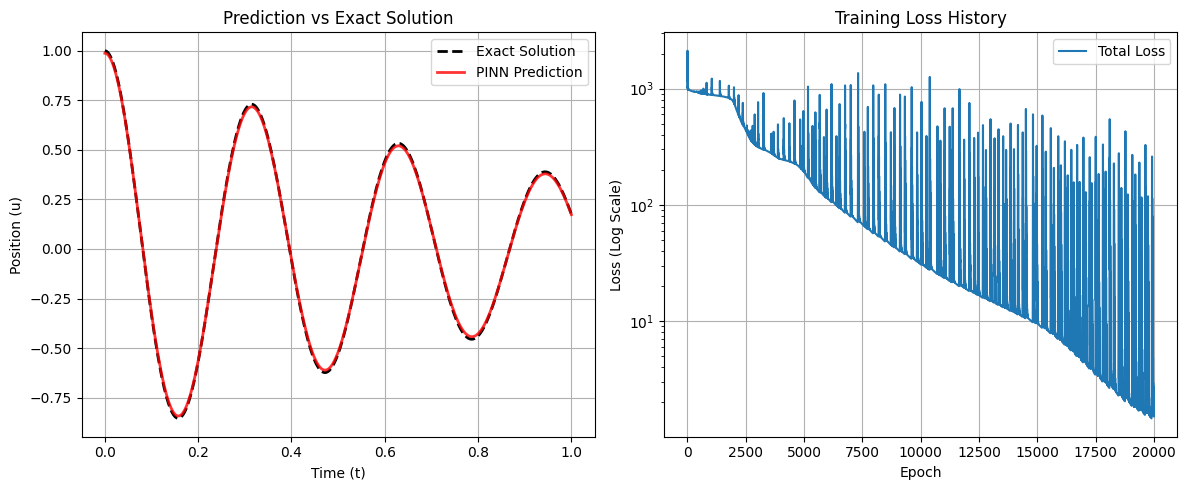

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1. 설정 및 초기화 (Configuration)
# -----------------------------------------------------------
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# 하이퍼파라미터 설정
EPOCHS = 20000          # 학습 횟수
LEARNING_RATE = 1e-3    # 학습률
LAMBDA_IC = 1000.0      # [중요] 초기 조건(IC)에 부여할 가중치
                        # 물리 계수(k=400)가 크기 때문에 IC 가중치도 높여야 균형이 맞음

# -----------------------------------------------------------
# 2. PINN 모델 정의 (Model Architecture)
# -----------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # 진동 주파수가 높으므로(k=400), 뉴런 수를 32 -> 64로 늘려 표현력 강화
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),          # 미분 가능한 활성화 함수
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.net(t)

# -----------------------------------------------------------
# 3. 물리 법칙 계산 함수 (Physics Calculation)
# -----------------------------------------------------------
def get_physics_loss(model, t):
    """
    물리 방정식의 잔차(Residual)를 계산합니다.
    목표 방정식: m*u'' + mu*u' + k*u = 0
    """
    t.requires_grad = True # 미분 추적 시작
    
    u = model(t)
    
    # 자동 미분 (Automatic Differentiation)
    # u_t = du/dt
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    # u_tt = d^2u/dt^2
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]
    
    # 물리 상수
    m = 1.0
    mu = 2.0
    k = 400.0 
    
    # 잔차(Residual) 계산: 0이 되어야 정답
    residual = m*u_tt + mu*u_t + k*u
    
    # MSE Loss 반환
    return torch.mean(residual ** 2)

# -----------------------------------------------------------
# 4. 데이터 준비 (Data Preparation)
# -----------------------------------------------------------
# (1) Collocation Points: 물리 법칙을 검사할 시간 영역 (0 ~ 1초)
t_physics = torch.linspace(0, 1, 400).view(-1, 1).requires_grad_(True)

# (2) Initial Condition (IC): 초기 조건 (t=0, u=1)
t_ic = torch.zeros(1, 1).requires_grad_(True)
u_ic_target = torch.tensor([[1.0]]) 
# 참고: 속도 초기 조건(u'(0)=0)도 필요하지만, 이 예제에서는 위치만 고정해도 학습됨

# 모델 및 옵티마이저 생성
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -----------------------------------------------------------
# 5. 학습 루프 (Training Loop)
# -----------------------------------------------------------
print(f"🚀 학습 시작 (IC 가중치: {LAMBDA_IC})")
print("-" * 60)

loss_history = []

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    # Loss 1: 초기 조건 (u(0) = 1)
    u_ic_pred = model(t_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic_target) ** 2)
    
    # Loss 2: 물리 법칙 (방정식 잔차)
    loss_phy = get_physics_loss(model, t_physics)
    
    # [핵심] Total Loss = 가중치 * IC_Loss + Physics_Loss
    # 가중치가 없으면 loss_phy가 너무 커서 loss_ic가 무시됨
    total_loss = (LAMBDA_IC * loss_ic) + loss_phy
    
    total_loss.backward()
    optimizer.step()
    
    loss_history.append(total_loss.item())
    
    if epoch % 2000 == 0:
        print(f"Epoch {epoch:5d} | Total: {total_loss.item():.6f} | "
              f"IC Loss: {loss_ic.item():.6f} | Physics: {loss_phy.item():.6f}")

print("-" * 60)
print("✅ 학습 완료!")

# -----------------------------------------------------------
# 6. 결과 검증 및 시각화 (Validation & Visualization)
# -----------------------------------------------------------
model.eval()

# (1) 예측값 생성
t_test = torch.linspace(0, 1, 300).view(-1, 1)
with torch.no_grad():
    u_pred = model(t_test).numpy()

# (2) 정답(Exact Solution) 계산
# 방정식: u'' + 2u' + 400u = 0, u(0)=1, u'(0)=0
t_np = t_test.numpy()
delta = 1.0  # damping term (mu / 2m)
omega_0 = 20.0 # natural frequency (sqrt(k/m))
omega = np.sqrt(omega_0**2 - delta**2) # damped frequency

# 해석해 공식
u_exact = np.exp(-delta * t_np) * (np.cos(omega * t_np) + (delta/omega) * np.sin(omega * t_np))

# (3) 그래프 그리기
plt.figure(figsize=(12, 5))

# 결과 비교 그래프
plt.subplot(1, 2, 1)
plt.title("Prediction vs Exact Solution")
plt.plot(t_np, u_exact, 'k--', label='Exact Solution', linewidth=2)
plt.plot(t_np, u_pred, 'r-', label='PINN Prediction', linewidth=2, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('Position (u)')
plt.legend()
plt.grid(True)

# 학습 로그 그래프 (Log Scale)
plt.subplot(1, 2, 2)
plt.title("Training Loss History")
plt.plot(loss_history, label='Total Loss')
plt.yscale('log') # 로그 스케일로 봐야 수렴 과정이 잘 보임
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

* **목표:** 판 전체의 온도 분포 u(x, y) 예측

2차원 열평형 문제는 시간이 흘러 온도가 더 이상 변하지 않는 상태, 즉 **라플라스 방정식 (Laplace Equation)**을 푸는 문제입니다.

###📝 문제 설정 (2D Plate)* **영역:** 0 \le x \le 1, 0 \le y \le 1 인 정사각형 금속 판
* **경계 조건 (Boundary Conditions):**
* **위쪽 벽 (y=1):** u=1 (뜨거움)
* **나머지 3면:** u=0 (차가움)

1. **입력 차원 확장:** `nn.Linear(2, ...)`로 변경하여 (x, y) 좌표를 동시에 받습니다.
2. **편미분 계산:** `torch.autograd.grad`를 사용하여 x와 y에 대해 각각 두 번 미분(u_{xx}, u_{yy})합니다.
3. **라플라스 방정식:** u_{xx} + u_{yy} = 0 이 물리적 제약 조건이 됩니다.
4. 

Using device: cuda
🚀 2D Heat Equation 학습 시작...


/home/ubuntu/miniconda3/envs/jupyter/lib/python3.10/site-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Total 3.71188 (BC: 0.37013, Phy: 0.01058)
Epoch 1000: Total 0.20295 (BC: 0.02002, Phy: 0.00273)
Epoch 2000: Total 0.18317 (BC: 0.01806, Phy: 0.00255)
Epoch 3000: Total 0.15255 (BC: 0.01473, Phy: 0.00523)
Epoch 4000: Total 0.11710 (BC: 0.01113, Phy: 0.00576)
Epoch 5000: Total 0.09336 (BC: 0.00878, Phy: 0.00554)
Epoch 6000: Total 0.10711 (BC: 0.00794, Phy: 0.02766)
Epoch 7000: Total 0.07923 (BC: 0.00737, Phy: 0.00551)
Epoch 8000: Total 0.07296 (BC: 0.00704, Phy: 0.00256)
Epoch 9000: Total 0.07549 (BC: 0.00680, Phy: 0.00751)
Epoch 10000: Total 0.06929 (BC: 0.00658, Phy: 0.00349)
Epoch 11000: Total 0.07193 (BC: 0.00637, Phy: 0.00824)
Epoch 12000: Total 0.06655 (BC: 0.00622, Phy: 0.00439)
Epoch 13000: Total 0.06533 (BC: 0.00605, Phy: 0.00479)
Epoch 14000: Total 0.06298 (BC: 0.00586, Phy: 0.00437)
Epoch 15000: Total 0.06161 (BC: 0.00572, Phy: 0.00438)
Epoch 16000: Total 0.05820 (BC: 0.00559, Phy: 0.00234)
Epoch 17000: Total 0.06595 (BC: 0.00548, Phy: 0.01112)
Epoch 18000: Total 0.05

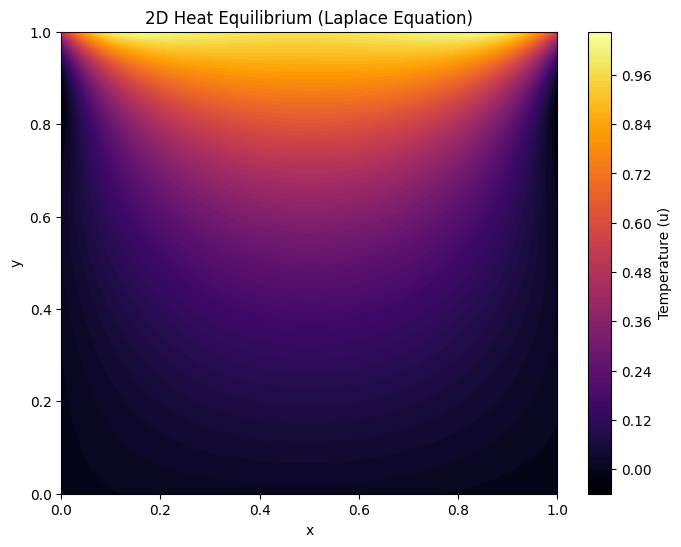

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 재현성 확보
torch.manual_seed(42)
np.random.seed(42)

# Device 설정 (GPU가 있으면 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------------------------------------
# 1. PINN 모델 정의 (Inputs: x, y -> Output: u)
# -----------------------------------------------------------
class PINN_2D(nn.Module):
    def __init__(self):
        super(PINN_2D, self).__init__()
        # 입력 2개 (x, y) -> 은닉층 -> 출력 1개 (Temperature u)
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, y):
        # x, y를 결합하여 입력으로 사용
        input_data = torch.cat([x, y], dim=1)
        return self.net(input_data)

# -----------------------------------------------------------
# 2. 물리 법칙 (Laplace Equation)
# d^2u/dx^2 + d^2u/dy^2 = 0
# -----------------------------------------------------------
def laplace_loss(model, x, y):
    x.requires_grad = True
    y.requires_grad = True
    
    u = model(x, y)
    
    # 1. First derivatives (u_x, u_y)
    # grad outputs는 튜플이므로 [0]을 가져옴
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    # 2. Second derivatives (u_xx, u_yy)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # Laplace Equation: u_xx + u_yy = 0
    residual = u_xx + u_yy
    
    return torch.mean(residual ** 2)

# -----------------------------------------------------------
# 3. 데이터 생성 (Collocation Points & Boundaries)
# -----------------------------------------------------------
# (1) 내부 점들 (Collocation Points) - 물리 법칙 학습용
N_collocation = 4000
x_col = torch.rand(N_collocation, 1).to(device)
y_col = torch.rand(N_collocation, 1).to(device)

# (2) 경계 조건 (Boundary Conditions)
N_boundary = 1000 # 각 벽마다 점 개수

# Top Wall (y=1, u=1) - HOT
x_top = torch.rand(N_boundary, 1).to(device)
y_top = torch.ones(N_boundary, 1).to(device)
u_top = torch.ones(N_boundary, 1).to(device)

# Bottom Wall (y=0, u=0) - COLD
x_bot = torch.rand(N_boundary, 1).to(device)
y_bot = torch.zeros(N_boundary, 1).to(device)
u_bot = torch.zeros(N_boundary, 1).to(device)

# Left Wall (x=0, u=0) - COLD
x_left = torch.zeros(N_boundary, 1).to(device)
y_left = torch.rand(N_boundary, 1).to(device)
u_left = torch.zeros(N_boundary, 1).to(device)

# Right Wall (x=1, u=0) - COLD
x_right = torch.ones(N_boundary, 1).to(device)
y_right = torch.rand(N_boundary, 1).to(device)
u_right = torch.zeros(N_boundary, 1).to(device)

# 경계 데이터 합치기
x_bc = torch.cat([x_top, x_bot, x_left, x_right], dim=0)
y_bc = torch.cat([y_top, y_bot, y_left, y_right], dim=0)
u_bc = torch.cat([u_top, u_bot, u_left, u_right], dim=0)

# -----------------------------------------------------------
# 4. 학습 (Training)
# -----------------------------------------------------------
model = PINN_2D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20000
LAMBDA_BC = 10.0 # 경계 조건 가중치 (필요시 조절)

print("🚀 2D Heat Equation 학습 시작...")

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    # Loss 1: Boundary Condition Loss (데이터 손실)
    u_pred_bc = model(x_bc, y_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc) ** 2)
    
    # Loss 2: Physics Loss (라플라스 방정식)
    loss_phy = laplace_loss(model, x_col, y_col)
    
    # Total Loss
    loss = loss_bc * LAMBDA_BC + loss_phy
    
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Total {loss.item():.5f} (BC: {loss_bc.item():.5f}, Phy: {loss_phy.item():.5f})")

print("✅ 학습 완료!")

# -----------------------------------------------------------
# 5. 결과 시각화 (Heatmap)
# -----------------------------------------------------------
# 격자 생성 (Meshgrid)
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# 텐서 변환
x_test = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
y_test = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_test, y_test).cpu().numpy()

# 2D 형태로 변환
U = u_pred.reshape(100, 100)

plt.figure(figsize=(8, 6))
plt.title("2D Heat Equilibrium (Laplace Equation)")
# 컨투어 플롯 (등고선 + 색상)
cntr = plt.contourf(X, Y, U, levels=100, cmap='inferno') 
plt.colorbar(cntr, label="Temperature (u)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
# CFD 

🚀 Navier-Stokes 학습 시작...
Epoch 0: Total 1.52209 | Phy 0.00350
Epoch 500: Total 0.08326 | Phy 0.04382
Epoch 1000: Total 0.03899 | Phy 0.02436
Epoch 1500: Total 0.02959 | Phy 0.01894
Epoch 2000: Total 0.02350 | Phy 0.01527
Epoch 2500: Total 0.01633 | Phy 0.01145
Epoch 3000: Total 0.00932 | Phy 0.00708
Epoch 3500: Total 0.00623 | Phy 0.00440
Epoch 4000: Total 0.00386 | Phy 0.00300
Epoch 4500: Total 0.00296 | Phy 0.00224
Epoch 5000: Total 0.00227 | Phy 0.00179
Epoch 5500: Total 0.00194 | Phy 0.00150
Epoch 6000: Total 0.00159 | Phy 0.00127
Epoch 6500: Total 0.00136 | Phy 0.00109
Epoch 7000: Total 0.00124 | Phy 0.00099
Epoch 7500: Total 0.00106 | Phy 0.00085
Epoch 8000: Total 0.00094 | Phy 0.00077
Epoch 8500: Total 0.00086 | Phy 0.00070
Epoch 9000: Total 0.00235 | Phy 0.00159
Epoch 9500: Total 0.00142 | Phy 0.00092
Epoch 10000: Total 0.00083 | Phy 0.00062
Epoch 10500: Total 0.00132 | Phy 0.00094
Epoch 11000: Total 0.00060 | Phy 0.00048
Epoch 11500: Total 0.00070 | Phy 0.00054
Epoch 12000: To

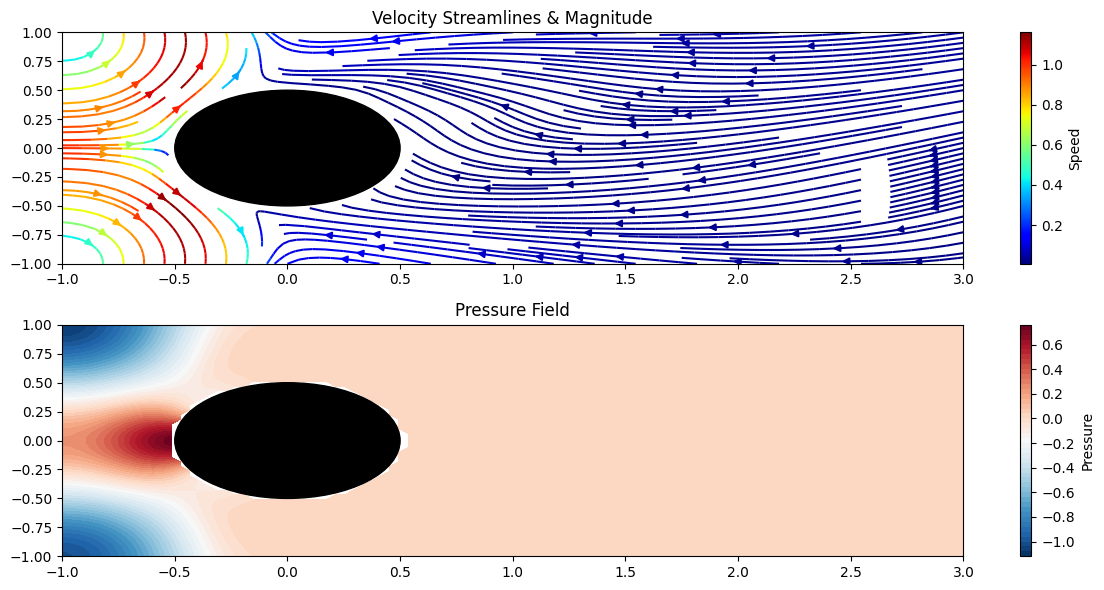

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# 1. PINN 모델 정의 (Inputs: x, y -> Outputs: u, v, p)
# -----------------------------------------------------------
class PINN_NS(nn.Module):
    def __init__(self):
        super(PINN_NS, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3) # Output: u (속도x), v (속도y), p (압력)
        )

    def forward(self, x, y):
        cat_input = torch.cat([x, y], dim=1)
        output = self.net(cat_input)
        u = output[:, 0:1]
        v = output[:, 1:2]
        p = output[:, 2:3]
        return u, v, p

# -----------------------------------------------------------
# 2. 나비에-스토크스 방정식 (Navier-Stokes Equations)
# -----------------------------------------------------------
def navier_stokes_loss(model, x, y):
    x.requires_grad = True
    y.requires_grad = True
    
    u, v, p = model(x, y)
    
    # 1차 미분
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, torch.ones_like(p), create_graph=True)[0]
    
    # 2차 미분
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, torch.ones_like(v_y), create_graph=True)[0]
    
    # 물리 상수 (Reynolds Number 관련)
    rho = 1.0
    nu = 0.01 # 점성 계수 (Viscosity)
    
    # Momentum Equations (x, y)
    # (u*ux + v*uy) = -px + nu*(uxx + uyy)
    f_u = (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)
    f_v = (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)
    
    # Continuity Equation (Mass Conservation)
    # ux + vy = 0
    f_c = u_x + v_y
    
    loss_ns = torch.mean(f_u**2) + torch.mean(f_v**2) + torch.mean(f_c**2)
    return loss_ns

# -----------------------------------------------------------
# 3. 데이터 생성 (직사각형 영역 - 원형 장애물)
# -----------------------------------------------------------
# 영역 설정: x [-1, 3], y [-1, 1], 원 중심(0,0), 반지름 0.5
def is_inside_circle(x, y, r=0.5):
    return x**2 + y**2 < r**2

# (1) Collocation Points (내부 점)
N_col = 5000
# 전체 직사각형에서 무작위 샘플링 후 원 내부 점 제거 (Rejection Sampling)
x_rand = np.random.uniform(-1, 3, (N_col*2, 1))
y_rand = np.random.uniform(-1, 1, (N_col*2, 1))
mask = ~is_inside_circle(x_rand, y_rand, r=0.5).flatten() # 원 밖만 선택
x_col = torch.tensor(x_rand[mask][:N_col], dtype=torch.float32).to(device)
y_col = torch.tensor(y_rand[mask][:N_col], dtype=torch.float32).to(device)

# (2) 경계 조건 생성
N_b = 200

# Inlet (x=-1): Parabolic profile u = 1 - y^2, v = 0
y_in = np.linspace(-1, 1, N_b).reshape(-1, 1)
x_in = np.full_like(y_in, -1)
u_in_val = 1 - y_in**2
v_in_val = np.zeros_like(y_in)

# Outlet (x=3): Pressure = 0 (일반적인 유출 조건)
y_out = np.linspace(-1, 1, N_b).reshape(-1, 1)
x_out = np.full_like(y_out, 3)
p_out_val = np.zeros_like(y_out)

# Walls (y=1, y=-1): No-slip (u=0, v=0)
x_wall = np.random.uniform(-1, 3, (N_b*2, 1))
y_wall = np.concatenate([np.ones((N_b, 1)), -1 * np.ones((N_b, 1))])
u_wall_val = np.zeros_like(y_wall)
v_wall_val = np.zeros_like(y_wall)

# Cylinder Surface (r=0.5): No-slip (u=0, v=0)
theta = np.linspace(0, 2*np.pi, N_b).reshape(-1, 1)
x_cyl = 0.5 * np.cos(theta)
y_cyl = 0.5 * np.sin(theta)
u_cyl_val = np.zeros_like(x_cyl)
v_cyl_val = np.zeros_like(x_cyl)

# 텐서 변환
x_in_t = torch.tensor(x_in, dtype=torch.float32).to(device).requires_grad_(True)
y_in_t = torch.tensor(y_in, dtype=torch.float32).to(device).requires_grad_(True)
u_in_t = torch.tensor(u_in_val, dtype=torch.float32).to(device)
v_in_t = torch.tensor(v_in_val, dtype=torch.float32).to(device)

x_cyl_t = torch.tensor(x_cyl, dtype=torch.float32).to(device).requires_grad_(True)
y_cyl_t = torch.tensor(y_cyl, dtype=torch.float32).to(device).requires_grad_(True)

# -----------------------------------------------------------
# 4. 학습 루프
# -----------------------------------------------------------
model = PINN_NS().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20000 # 시간 관계상 5000번만 (수렴하려면 더 필요함)

print("🚀 Navier-Stokes 학습 시작...")

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    # [Loss 1] Physics Loss (Domain 내부)
    loss_phy = navier_stokes_loss(model, x_col, y_col)
    
    # [Loss 2] Boundary Conditions
    # 2.1 Inlet (속도 고정)
    u_pred_in, v_pred_in, _ = model(x_in_t, y_in_t)
    loss_inlet = torch.mean((u_pred_in - u_in_t)**2) + torch.mean((v_pred_in - v_in_t)**2)
    
    # 2.2 Cylinder Surface (속도 0)
    u_pred_cyl, v_pred_cyl, _ = model(x_cyl_t, y_cyl_t)
    loss_cyl = torch.mean(u_pred_cyl**2) + torch.mean(v_pred_cyl**2)
    
    # Total Loss (가중치 조절 중요)
    loss = loss_phy + 2.0 * (loss_inlet + loss_cyl)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total {loss.item():.5f} | Phy {loss_phy.item():.5f}")

print("✅ 학습 완료!")

# -----------------------------------------------------------
# 5. 유동 가시화 (Streamplot)
# -----------------------------------------------------------
x = np.linspace(-1, 3, 100)
y = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(x, y)

# 마스킹 (원 내부 데이터는 NaN 처리하여 그리지 않음)
mask_plot = is_inside_circle(X, Y)

x_test = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
y_test = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred, v_pred, p_pred = model(x_test, y_test)
    u_plot = u_pred.cpu().numpy().reshape(50, 100)
    v_plot = v_pred.cpu().numpy().reshape(50, 100)
    p_plot = p_pred.cpu().numpy().reshape(50, 100)

# 원 내부 지우기
u_plot[mask_plot] = np.nan
v_plot[mask_plot] = np.nan
p_plot[mask_plot] = np.nan

plt.figure(figsize=(12, 6))

# 속도 유선 (Streamlines)
plt.subplot(2, 1, 1)
plt.title("Velocity Streamlines & Magnitude")
speed = np.sqrt(u_plot**2 + v_plot**2)
strm = plt.streamplot(X, Y, u_plot, v_plot, color=speed, cmap='jet', density=1.5)
plt.colorbar(strm.lines, label="Speed")
# 원 그리기
circle = plt.Circle((0,0), 0.5, color='black', zorder=10)
plt.gca().add_patch(circle)
plt.xlim(-1, 3)
plt.ylim(-1, 1)

# 압력장 (Pressure Field)
plt.subplot(2, 1, 2)
plt.title("Pressure Field")
plt.contourf(X, Y, p_plot, levels=50, cmap='RdBu_r')
plt.colorbar(label="Pressure")
circle2 = plt.Circle((0,0), 0.5, color='black', zorder=10)
plt.gca().add_patch(circle2)
plt.xlim(-1, 3)
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

Using device: cuda
🚀 Transient CFD 학습 시작 (애니메이션을 위해 시간이 걸립니다)...
Epoch 0: Loss 4.91154 (Phy: 0.00314)
Epoch 500: Loss 0.17056 (Phy: 0.01769)
Epoch 1000: Loss 0.15692 (Phy: 0.01656)
Epoch 1500: Loss 0.12529 (Phy: 0.01223)
Epoch 2000: Loss 0.10604 (Phy: 0.00947)
Epoch 2500: Loss 0.09600 (Phy: 0.00823)
Epoch 3000: Loss 0.08549 (Phy: 0.00793)
Epoch 3500: Loss 0.08199 (Phy: 0.00956)
Epoch 4000: Loss 0.06963 (Phy: 0.00869)
Epoch 4500: Loss 0.06916 (Phy: 0.00882)
Epoch 5000: Loss 0.06016 (Phy: 0.00904)
Epoch 5500: Loss 0.05362 (Phy: 0.00802)
Epoch 6000: Loss 0.07098 (Phy: 0.01067)
Epoch 6500: Loss 0.04462 (Phy: 0.00737)
Epoch 7000: Loss 0.04674 (Phy: 0.00758)
Epoch 7500: Loss 0.03928 (Phy: 0.00617)
Epoch 8000: Loss 0.03668 (Phy: 0.00614)
Epoch 8500: Loss 0.03643 (Phy: 0.00578)
Epoch 9000: Loss 0.03502 (Phy: 0.00626)
Epoch 9500: Loss 0.02822 (Phy: 0.00561)
Epoch 10000: Loss 0.02545 (Phy: 0.00528)
Epoch 10500: Loss 0.02487 (Phy: 0.00548)
Epoch 11000: Loss 0.02211 (Phy: 0.00491)
Epoch 11500: Los

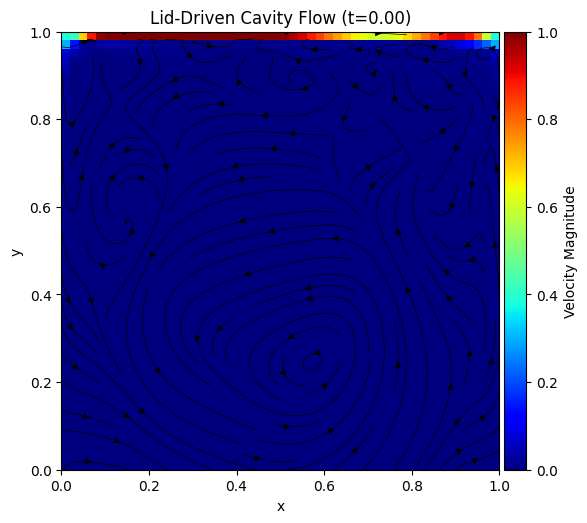

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 설정
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 하이퍼파라미터
NU = 0.01 # 점성 계수 (낮을수록 난류에 가까워짐, 학습 어려움)
T_MAX = 1.0 # 최대 시뮬레이션 시간
EPOCHS = 50000 # 데모용으로 짧게 설정 (실제로는 50,000+ 권장)
LR = 1e-3

# -----------------------------------------------------------
# 1. PINN 모델 정의 (Inputs: t, x, y -> Outputs: u, v, p)
# -----------------------------------------------------------
class PINN_Transient(nn.Module):
    def __init__(self):
        super(PINN_Transient, self).__init__()
        # 입력 3개 (t, x, y)
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 3) # u, v, p
        )

    def forward(self, t, x, y):
        cat_input = torch.cat([t, x, y], dim=1)
        output = self.net(cat_input)
        return output[:, 0:1], output[:, 1:2], output[:, 2:3] # u, v, p

# -----------------------------------------------------------
# 2. 시간 의존 Navier-Stokes 방정식 Loss
# -----------------------------------------------------------
def physics_loss(model, t, x, y):
    t.requires_grad = True
    x.requires_grad = True
    y.requires_grad = True
    
    u, v, p = model(t, x, y)
    
    # 1차 미분 (시간 t에 대한 미분 추가!)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    
    p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, torch.ones_like(p), create_graph=True)[0]
    
    # 2차 미분
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, torch.ones_like(v_y), create_graph=True)[0]
    
    # Transient Navier-Stokes Momentum (du/dt 항 추가)
    f_u = u_t + (u*u_x + v*u_y) + p_x - NU*(u_xx + u_yy)
    f_v = v_t + (u*v_x + v*v_y) + p_y - NU*(v_xx + v_yy)
    f_c = u_x + v_y # Continuity
    
    return torch.mean(f_u**2) + torch.mean(f_v**2) + torch.mean(f_c**2)

# -----------------------------------------------------------
# 3. 데이터 생성 (Initial & Boundary Conditions)
# -----------------------------------------------------------
N_col = 5000
N_bc = 500

# (1) Collocation Points (시공간 내부)
t_col = torch.rand(N_col, 1).to(device) * T_MAX
x_col = torch.rand(N_col, 1).to(device)
y_col = torch.rand(N_col, 1).to(device)

# (2) Initial Condition (IC): t=0 일 때 정지 상태 (u=0, v=0)
t_ic = torch.zeros(N_bc, 1).to(device)
x_ic = torch.rand(N_bc, 1).to(device)
y_ic = torch.rand(N_bc, 1).to(device)
u_ic_target = torch.zeros_like(x_ic)
v_ic_target = torch.zeros_like(x_ic)

# (3) Boundary Conditions (BC) - 매 시간 단계에서 적용
# Top Lid (y=1): u=1 moving, v=0
t_bc_top = torch.rand(N_bc, 1).to(device) * T_MAX
x_bc_top = torch.rand(N_bc, 1).to(device)
y_bc_top = torch.ones(N_bc, 1).to(device)
u_bc_top_target = torch.ones_like(x_bc_top)
v_bc_top_target = torch.zeros_like(x_bc_top)

# Walls (Left/Right/Bottom): u=0, v=0 No-slip
t_bc_wall = torch.rand(N_bc*3, 1).to(device) * T_MAX
# x=0, x=1, y=0 좌표 생성
x_wall = torch.cat([torch.zeros(N_bc,1), torch.ones(N_bc,1), torch.rand(N_bc,1)], dim=0).to(device)
y_wall = torch.cat([torch.rand(N_bc,1), torch.rand(N_bc,1), torch.zeros(N_bc,1)], dim=0).to(device)
u_bc_wall_target = torch.zeros_like(x_wall)
v_bc_wall_target = torch.zeros_like(x_wall)


# -----------------------------------------------------------
# 4. 학습 루프
# -----------------------------------------------------------
model = PINN_Transient().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("🚀 Transient CFD 학습 시작 (애니메이션을 위해 시간이 걸립니다)...")

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    # Physics Loss
    loss_phy = physics_loss(model, t_col, x_col, y_col)
    
    # IC Loss (t=0)
    u_ic, v_ic, _ = model(t_ic, x_ic, y_ic)
    loss_ic = torch.mean((u_ic - u_ic_target)**2) + torch.mean((v_ic - v_ic_target)**2)
    
    # BC Loss (Walls & Top Lid)
    u_top, v_top, _ = model(t_bc_top, x_bc_top, y_bc_top)
    loss_bc_top = torch.mean((u_top - u_bc_top_target)**2) + torch.mean((v_top - v_bc_top_target)**2)
    
    u_wall, v_wall, _ = model(t_bc_wall, x_wall, y_wall)
    loss_bc_wall = torch.mean((u_wall - u_bc_wall_target)**2) + torch.mean((v_wall - v_bc_wall_target)**2)
    
    # Total Loss (가중치 조절)
    loss = loss_phy + 5.0*(loss_ic + loss_bc_top + loss_bc_wall)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.5f} (Phy: {loss_phy.item():.5f})")

print("✅ 학습 완료! 애니메이션 생성 중...")

# -----------------------------------------------------------
# 5. 애니메이션 생성 (Matplotlib Animation)
# -----------------------------------------------------------
model.eval()

# 공간 격자 생성
x_np = np.linspace(0, 1, 50)
y_np = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x_np, y_np)
x_grid = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
y_grid = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)

# 시간 프레임 설정
time_frames = np.linspace(0, T_MAX, 60) # 60 프레임
predictions = []

# 각 시간 단계별 예측값 저장
with torch.no_grad():
    for t_val in time_frames:
        t_grid = torch.full_like(x_grid, t_val)
        u_pred, v_pred, p_pred = model(t_grid, x_grid, y_grid)
        
        u_plot = u_pred.cpu().numpy().reshape(50, 50)
        v_plot = v_pred.cpu().numpy().reshape(50, 50)
        speed = np.sqrt(u_plot**2 + v_plot**2)
        predictions.append((u_plot, v_plot, speed, t_val))

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# 첫 프레임 초기화
u0, v0, speed0, t0 = predictions[0]
im = ax.imshow(speed0, extent=[0, 1, 0, 1], origin='lower', cmap='jet', vmin=0, vmax=1.0)
cb = fig.colorbar(im, cax=cax)
cb.set_label('Velocity Magnitude')
strm = ax.streamplot(X, Y, u0, v0, color='k', linewidth=0.5, density=1.0)
title = ax.set_title(f"Lid-Driven Cavity Flow (t={t0:.2f})")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("x")
ax.set_ylabel("y")

def update(frame_idx):
    global strm # 이전 streamplot을 지우기 위해 전역 변수 사용
    
    u, v, speed, t = predictions[frame_idx]
    
    # 이미지(속도 크기) 업데이트
    im.set_data(speed)
    
    # 이전 유선 지우고 새로 그리기
    if strm:
        strm.lines.remove()
        for art in ax.get_children():
             if isinstance(art, matplotlib.patches.FancyArrowPatch): 
                 art.remove()

    strm = ax.streamplot(X, Y, u, v, color='k', linewidth=0.5, density=1.0)
    
    # 제목 업데이트
    title.set_text(f"Lid-Driven Cavity Flow (t={t:.2f})")
    return im, title

# 애니메이션 생성
import matplotlib
ani = animation.FuncAnimation(fig, update, frames=len(time_frames), interval=100, blit=False)

# GIF로 저장 (ImageMagick 또는 ffmpeg 필요할 수 있음. 오류 시 'pillow' 사용)
save_path = "flow_animation.gif"
try:
    ani.save(save_path, writer='pillow', fps=15)
    print(f"🎉 애니메이션 저장 완료: {save_path}")
except Exception as e:
    print(f"애니메이션 저장 실패: {e}")
    plt.show() # 저장 실패 시 화면에 표시